In [136]:
import numpy as np
import math
from sympy.geometry import *
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.animation as animation

# リンクのパラメータ設定

In [137]:
link1_length = 4.0
theta1 = 80 # 駆動範囲：-90〜90度
theta1 = np.radians(theta1)
link2_length = 2.0
theta2 = -100 # 駆動範囲：-160〜160度
theta2 = np.radians(theta2)

# 同時変換行列

In [138]:
# 同時変換行列
def H_2d(x, y, theta):     
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta),  np.cos(theta), y],
                     [            0,              0, 1]])

# link1 -> link2 の同時変換行列
link_1to2 = H_2d(link1_length*np.cos(theta1), link1_length*np.sin(theta1), theta1)
# link2 -> end effector の同時変換行列
link_2toe = H_2d(link2_length*np.cos(theta2), link2_length*np.sin(theta2), theta2)
# link1 -> end effector の同時変換行列
link_1toe = link_1to2@link_2toe

# 各リンクとエンドエフェクタの座標

In [139]:
# link2の原点座標
x2, y2 = link_1to2[0][2], link_1to2[1][2]
# end effectorの原点座標
xe, ye = link_1toe[0][2], link_1toe[1][2]

# --------------------------------
# 三角関数による
# to_e = np.array([[link2_length],
#                  [0.0],
#                  [1]])
# x2, y2 = link1_length*np.cos(theta1),  link1_length*np.sin(theta1)
# xe, ye = x2 + link2_length*np.cos(theta1+theta2), y2 + link2_length*np.sin(theta1+theta2)

# --------------------------------------------------
print("ロボットアームの根元 -> 手先までの距離(x, y)", xe, ye)

ロボットアームの根元 -> 手先までの距離(x, y) 2.573977952239538 3.2551907253974948


# 障害物のパラメータ設定

In [140]:
# 矩形の障害物
obs_x = 3.0
obs_y = 2.0
obs_w = 1.0
obs_h = 1.0

# カメラによる距離測定

In [141]:
# カメラからの距離を測定 ---------------------------------
lidar_length = 5.0 # レーザーの最大距離
xac, yac = xe, ye # ロボットアーム座標系から見たカメラ座標系の原点（今回は，ロボットアームの手先=カメラ座標原点としている）
lidar_resolution = 0.01 # lidarの分解能
xce, yce = xe, ye # レーザーの先端座標（初期時点では，原点と一致．以下のfor文内で更新）
lidar_to_obs = 0.0 # カメラ座標原点->障害物までの距離

# レーザーが障害物（矩形）と衝突しているかどうか判定
# 実空間では，距離センサから得られる値をそのまま使用すればよい（シミュレータの時にだけ必要な処理）
# （実空間で使用する場合の例）距離センサの値がOO以下なら，その座標まで手先を持っていく
for l in range(int(lidar_length*(1/lidar_resolution))):
    lidar_point = l*lidar_resolution # lidar_lengthにたどり着くまで(lidar_resolution/lidar_length)ずつレーザーを伸ばしていく
    xce, yce = xac + lidar_point*np.cos(theta1+theta2), yac + lidar_point*np.sin(theta1+theta2)
    # 衝突判定には「点（レーザーの1点）」と「矩形（障害物）」間の衝突判定を使用
    if xce >= obs_x and xce <= (obs_x+obs_w) and yce >= obs_y and yce <= (obs_y+obs_h):
        lidar_to_obs = lidar_point
        break # 衝突
    else:
        pass # 非衝突  
#print("arm to obs (true)", xce, yce)

# 「カメラ座標系原点->障害物」までのx方向の距離
# （今回は「手先座標原点=カメラ座標系原点」なので，「カメラ座標系原点->障害物までの距離」と等しい）
# （「手先座標原点≠カメラ座標系原点」の場合は，「手先の原点->カメラの原点」の座標変換も必要であることに注意）
xl = lidar_to_obs 
yl = 0.0 # カメラ座標系原点->障害物までのy方向の距離（今回は0.0）

# 「カメラ座標系 -> ロボットアーム座標系（原点）」に変更
link_1_to_lidar = link_1toe # 今回の場合は，手先の原点と，lidarの原点が同じと仮定
lidar_to_obs = np.array([[xl],
                         [yl],
                         [1]])
link_to_obs = link_1_to_lidar@lidar_to_obs
print("「リンク座標系の原点」から「レーザーの先端」までの距離", link_to_obs[0][0], link_to_obs[1][0])


「リンク座標系の原点」から「レーザーの先端」までの距離 3.2787474178289693 2.998675617903243


# 描画

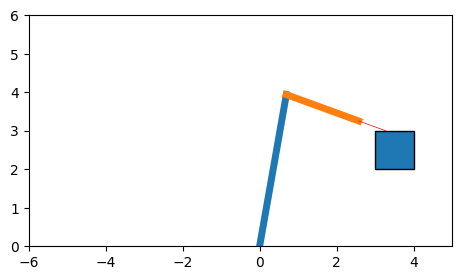

In [142]:
# 描画 -------------------------------------------
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_aspect("equal")#画像の比率を同じにする
x0, y0 = 0, 0
plt.axes(ax1)



# 描画範囲：リンクを伸ばし切った時の長さを描画範囲に設定
#ax1.set_xlim(-(link1_length+link2_length), link1_length+link2_length)
# 描画範囲：y=0未満は描画しない
#ax1.set_ylim(0.0, link1_length+link2_length)

ax1.set_xlim(-(link1_length+link2_length), obs_x+obs_w+1.0)
ax1.set_ylim(0.0, link1_length+link2_length)


s0 = Segment(Point(0   , 0)   ,Point(x2, y2)) # リンク1
s1 = Segment(Point(x2, y2),Point(xe, ye)) # リンク2 
s2 = Segment(Point(xe, ye),Point(xce, yce)) # カメラ光
segments = [s0, s1, s2]

# 各リンクを描画
for i,s in enumerate(segments) :
    if i+1 == len(segments):
        break # レーザーはここでは描画しない
    ax1.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], lw=5)

#レーザーを描画
ax1.plot([xac, xce], [yac, yce], color="red", lw=0.5)

# 障害物（矩形）を描画
r = pat.Rectangle(xy=(obs_x, obs_y), width=obs_w, height=obs_h, ec='#000000', fill=True)
ax1.add_patch(r)

plt.show()



# レーザーの情報をもとに逆運動学により障害物に近づく

In [143]:
import inverse_kinematics
final_theta1, final_theta2 = inverse_kinematics.Inverse_kinematics(xe, ye, link_to_obs[0][0], link_to_obs[1][0], link1_length, link2_length, theta1, theta2)
deg1, deg2 = np.rad2deg(final_theta1), np.rad2deg(final_theta2)
print("final_theta1,final_theta2",deg1, deg2)

# link1 -> link2 の同時変換行列
link_1to2 = H_2d(link1_length*np.cos(final_theta1), link1_length*np.sin(final_theta1), final_theta1)
# link2 -> end effector の同時変換行列
link_2toe = H_2d(link2_length*np.cos(final_theta2), link2_length*np.sin(final_theta2), final_theta2)
# link1 -> end effector の同時変換行列
link_1toe = link_1to2@link_2toe

# link2の原点座標
x2, y2 = link_1to2[0][2], link_1to2[1][2]
# end effectorの原点座標
xe, ye = link_1toe[0][2], link_1toe[1][2]

number 1 x 2.6442834268856323 y 3.2288411076380115
number 2 x 2.707588185962751 y 3.205261215781433
number 3 x 2.764586823538969 y 3.1841481720194973
number 4 x 2.815905656702681 y 3.16523428139737
number 5 x 2.862109221928521 y 3.148282632979172
number 6 x 2.9037062381025276 y 3.133083278499427
number 7 x 2.9411550441192706 y 3.1194499188232108
number 8 x 2.9748685363816962 y 3.1072170316523726
number 9 x 3.005218639950575 y 3.0962373799010834
number 10 x 3.0325403502570785 y 3.086379847213708
number 11 x 3.057135382486605 y 3.0775275541852642
number 12 x 3.0792754643275613 y 3.0695762154434965
number 13 x 3.099205305560435 y 3.06243270363538
number 14 x 3.1171452754072866 y 3.056013791472375
number 15 x 3.1332938159346213 y 3.0502450473587155
number 16 x 3.147829617247937 y 3.045059863826896
number 17 x 3.160913577807576 y 3.0403986011197044
number 18 x 3.1726905709654902 y 3.0362078308740457
number 19 x 3.1832910367803926 y 3.032439667056804
number 20 x 3.1928324163111057 y 3.029051

# 描画

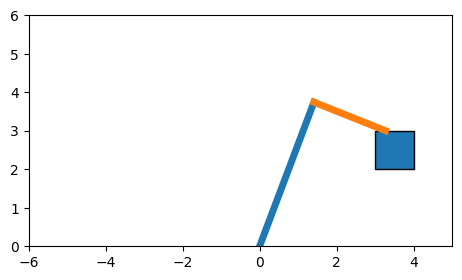

In [144]:
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_aspect("equal")#画像の比率を同じにする
x0, y0 = 0, 0
plt.axes(ax1)

ax1.set_xlim(-(link1_length+link2_length), obs_x+obs_w+1.0)
ax1.set_ylim(0.0, link1_length+link2_length)


s0 = Segment(Point(0   , 0)   ,Point(x2, y2)) # リンク1
s1 = Segment(Point(x2, y2),Point(xe, ye)) # リンク2 
segments = [s0, s1]

# 各リンクを描画
for i,s in enumerate(segments) :
    ax1.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], lw=5)

# 障害物（矩形）を描画
r = pat.Rectangle(xy=(obs_x, obs_y), width=obs_w, height=obs_h, ec='#000000', fill=True)
ax1.add_patch(r)

plt.show()
